In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer
from qiskit import execute
from qiskit.tools.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from IPython.display import Image

# Making a single qubit depolarizing error channel.
The aim is to use Qiskits built in depolarizing quantum error channel function
$\texttt{depolarizing\_error(param, num\_qubits, standard\_gates=True)}$ to create the desired depolarizing channel. It takes the depolarization parameter $\lambda$ and number of qubits $n$ to create the depolarizing channel
$$
\begin{equation}
    \label{eqn:depo-chan-qiskit}
    \varepsilon(\rho) = (1-\lambda)\rho + \lambda Tr\left[\rho\right]\frac{I}{2^{n}}
    \text{.}
\end{equation}$$

It can then be manipulated to create the single qubit depolarizing channel
$$
\begin{equation}
    \label{eqn:depo-chan-1qubit}
    \varepsilon(\rho_{single-qubit}) =    
    (1-P)\rho + \frac{P}{3}\left(X\rho X + Y\rho Y + Z\rho Z\right)
    \text{.}
\end{equation}$$
This is shown by the following derivation.

For a single qubit $n=1$
$$ \frac{I}{2^{1}} = \frac{1}{4} \left(I\rho I + X\rho X + Y\rho Y + Z\rho Z\right),$$
and $Tr[\rho] = 1.$

If we then chose 
$$\lambda=\frac{4^{n}P}{4^{n}-1},$$ 
where $P$ is the probability. At $n=1$ the depolarization paramater
$$\lambda = \frac{4P}{3}$$ and by substituting these results into $\varepsilon(\rho)$ we get that 

$$
\begin{align}
    \varepsilon(\rho) &= (1-\frac{4P}{3})\rho +  
        \frac{4P}{3} \left(I\rho I + X\rho X + Y\rho Y + Z\rho Z\right)
    \frac{1}{4} \\
                      &=  \left( 1 - \frac{4P}{3} + \frac{P}{3} \right)\rho
                        + \frac{P}{3} \left(X\rho X + Y\rho Y + Z\rho Z\right) \\
                       &= (1-P)\rho + \frac{P}{3}\left(X\rho X + Y\rho Y + Z\rho Z\right)
    \text{.}
\end{align}
$$

To prove that this works I wil be using a 2, 3 and 4 qubit system to show the affect of the depolarazation channel when $\lambda=\frac{4P}{3}$. The depolazation channel will act on every qubit indivually when a measuremnet is done. This means that every qubit wil experience a single qubit depolarazation channel of the form
$$\varepsilon(\rho_{single-qubit}) =    
    (1-P)\rho + \frac{P}{3}\left(X\rho X + Y\rho Y + Z\rho Z\right)$$

In [2]:
def get_noise(p, qubits=1):
    
    # This creates the depolarizing error channel,
    # epsilon(P) = (1-P)rho + (P/3)(XrhoX + YrhoY + ZrhoZ).
    depo_err_chan = depolarizing_error((4*p)/3, qubits)

    # Creating the noise model to be used during execution.
    noise_model = NoiseModel()

    noise_model.add_all_qubit_quantum_error(depo_err_chan, "measure") # measurement error is applied to measurements

    return noise_model, depo_err_chan

In [3]:
# The probability for depolarazation = 1, 
# Number of qubits = 1.
noise_model, depo_err_chan = get_noise(1,1)

In [4]:
# Properties of the depolarasation channel when P=1.
print(depo_err_chan)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.3333333333333333, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}]
  P(1) = 0.3333333333333333, QasmQobjInstructions = [[{'name': 'y', 'qubits': [0]}]
  P(2) = 0.3333333333333333, QasmQobjInstructions = [[{'name': 'z', 'qubits': [0]}]


When $P=1$ the total probability for a qubit to be flipped is 2/3. 
This is because of the $X$ and $Y$ operators both having a probability occuring of 1/3.
The total probability for a qubit to remain the same is 1/3.
This is because of $Z$ operator acting on the qubit.
As you can see this obeys the depolaration equation we want $\varepsilon(\rho_{single-qubit})$.
When $P=1$, $\varepsilon(\rho_{single-qubit})$ becomes

$$
\begin{align}
    \varepsilon(\rho_{single-qubit}) &=    
    (1-1)\rho + \frac{1}{3}\left(X\rho X + Y\rho Y + Z\rho Z\right) \\
                                    &=
    \frac{1}{3}\left(X\rho X + Y\rho Y + Z\rho Z\right)
\end{align}
$$
This shows that the $X$, $Y$ and $Z$ operators occur with a probability 1/3, just like it's shown in the properties of the depolarasation channel above.

In [5]:
# The structure of the noise model used during execution.
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'u3']
  Instructions with noise: ['measure']
  All-qubits errors: ['measure']


We expect from the depolarazation channel acting on a 1 qubit system with initial qubit states $q_{0} = |0>$ to flip the qubit state $q_{0}$ with a total probability $2/3$ and remain the same with a probability of $1/3$. This will then give us the 2 possible states $|0>$ and $|1>$.

In [6]:
qr = QuantumRegister(1)
cr = ClassicalRegister(1)
qc = QuantumCircuit(qr, cr)

In [7]:
qc.measure(0,0)

In [8]:
print(qc)

      ┌─┐
q0_0: ┤M├
      └╥┘
c0_0: ═╩═
         


In [9]:
counts = execute(qc, Aer.get_backend('qasm_simulator'), 
                  noise_model=noise_model,
                  shots=1000000).result().get_counts()

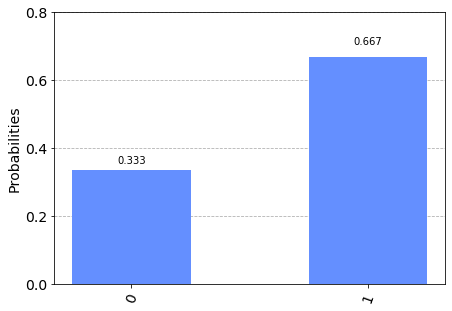

In [10]:
plot_histogram(counts)

In [11]:
print(counts)

{'1': 666688, '0': 333312}



|1-qubit state | Probability of the 1-qubit state  | Qiskit result |
|--------------|-----------------------------------|---------------|
|    $\vert 0>$ | $\frac{1}{3} = 0.333$ | 0.333|
|    $\vert 1>$ | $\frac{2}{3} = 0.666$ | 0.667|

From the results above you can see that the deporalizing error channel $\varepsilon(\rho_{single-qubit})$ works on the qubits like how it was expected with the small error due to statistical fluctuations involved in making measurements.


What we expect from the depolarazation channel acting on a 2 qubit system with initial qubit states $q_{0} = |0>$ and $q_{1} = |0>$ is that the $X$ and $Y$ will flip the individual qubit states $q_{0}$ and $q_{1}$ with a total probability $2/3$ and remain the same with a probability of $1/3$. This will then give us the 4 possible states $|00>$, $|01>$, $|10>$ and $|11>$.

In [12]:
qr2 = QuantumRegister(2)
cr2 = ClassicalRegister(2)
qc2 = QuantumCircuit(qr2, cr2)

In [13]:
qc2.measure(0,0)
qc2.measure(1,1)

In [14]:
print(qc2)

      ┌─┐   
q1_0: ┤M├───
      └╥┘┌─┐
q1_1: ─╫─┤M├
       ║ └╥┘
c1_0: ═╩══╬═
          ║ 
c1_1: ════╩═
            


In [15]:
counts2 = execute(qc2, Aer.get_backend('qasm_simulator'), 
                  noise_model=noise_model,
                  shots=1000000).result().get_counts()

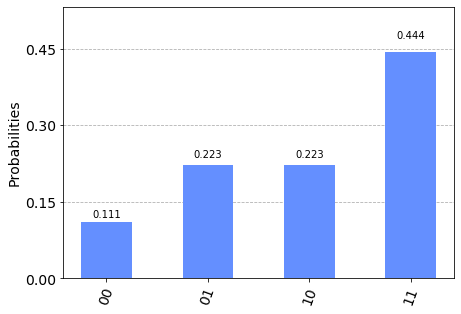

In [16]:
plot_histogram(counts2)

In [17]:
print(counts2)

{'01': 222551, '11': 443909, '00': 110806, '10': 222734}



|2-qubit state | Probability of the 2-qubit state  | Qiskit result |
|--------------|-----------------------------------|---------------|
|    $\vert 00>$ | $\frac{1}{3}\cdot \frac{1}{3} = \frac{1}{9}=0.111$ | 0.111|
|    $\vert 01>$ | $\frac{1}{3}\cdot \frac{2}{3} = \frac{2}{9}=0.222$ | 0.223|
|    $\vert 10>$ | $\frac{2}{3}\cdot \frac{1}{3} = \frac{2}{9}=0.222$ | 0.223|
|    $\vert 11>$ | $\frac{2}{3}\cdot \frac{2}{3} = \frac{4}{9}=0.444$ | 0.444|

From the results above you can see that the deporalizing error channel $\varepsilon(\rho_{single-qubit})$ works on the qubits like how it was expected with the small error due to statistical fluctuations involved in making measurements.


The same procedure applies to a 3 qubit system. With  
8 possible states $|000>$, $|001>$, $|010>$, $|011>$, $|100>$, $|101>$, $|110>$ and $|111>$.

In [18]:
qr3 = QuantumRegister(3)
cr3 = ClassicalRegister(3)
qc3 = QuantumCircuit(qr3, cr3)

In [19]:
qc3.measure(0,0)
qc3.measure(1,1)
qc3.measure(2,2)

In [20]:
print(qc3)

      ┌─┐      
q2_0: ┤M├──────
      └╥┘┌─┐   
q2_1: ─╫─┤M├───
       ║ └╥┘┌─┐
q2_2: ─╫──╫─┤M├
       ║  ║ └╥┘
c2_0: ═╩══╬══╬═
          ║  ║ 
c2_1: ════╩══╬═
             ║ 
c2_2: ═══════╩═
               


In [21]:
counts3 = execute(qc3, Aer.get_backend('qasm_simulator'), 
                  noise_model=noise_model,
                  shots=1000000).result().get_counts()

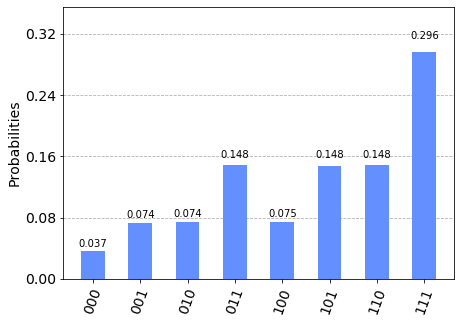

In [22]:
plot_histogram(counts3)

In [23]:
print(counts3)

{'011': 148411, '000': 36983, '111': 295825, '100': 74554, '101': 148018, '110': 148366, '001': 73579, '010': 74264}



|3-qubit state | Probability of the 3-qubit state  | Qiskit result |
|--------------|-----------------------------------|---------------|
|    $\vert 000>$ | $\frac{1}{3}\cdot \frac{1}{3}\cdot \frac{1}{3} = \frac{1}{27}=0.037$ | 0.037|
|    $\vert 001>$ | $\frac{1}{3}\cdot\frac{1}{3} \cdot \frac{2}{3} = \frac{2}{27}=0.074$ | 0.074|
|    $\vert 010>$ |  $\frac{1}{3}\cdot\frac{2}{3} \cdot \frac{1}{3} = \frac{2}{27}=0.074$ | 0.074|
|    $\vert 011>$ | $\frac{1}{3}\cdot \frac{2}{3}\cdot \frac{2}{3} = \frac{4}{27}=0.148$ | 0.148|
|    $\vert 100>$ | $\frac{2}{3}\cdot\frac{1}{3} \cdot \frac{1}{3} = \frac{2}{27}=0.074$ | 0.075|
|    $\vert 101>$ | $\frac{2}{3}\cdot \frac{1}{3}\cdot \frac{2}{3} = \frac{4}{27}=0.148$ | 0.148|
|    $\vert 110>$ | $\frac{2}{3}\cdot \frac{2}{3}\cdot \frac{1}{3} = \frac{4}{27}=0.148$ | 0.148|
|    $\vert 111>$ | $\frac{2}{3}\cdot \frac{2}{3}\cdot \frac{2}{3} = \frac{4}{27}=0.296$ | 0.296|

From the results above you can see that the deporalizing error channel $\varepsilon(\rho_{single-qubit})$ works on the qubits like how it was expected with the small error due to statistical fluctuations involved in making measurements.


The procedure holds for a 4 qubit system. With  
16 possible states $|0000>$, $|0001>$, $|0010>$, $|0011>$, $|0100>$, $|0101>$, $|0110>$, $|0111>$, $|1000>$, $|1001>$, $|1010>$, $|1011>$, $|1100>$, $|1101>$, $|1110>$ and $|1111>$

In [24]:
qr4 = QuantumRegister(4)
cr4 = ClassicalRegister(4)
qc4 = QuantumCircuit(qr4, cr4)

In [25]:
qc4.measure(0,0)
qc4.measure(1,1)
qc4.measure(2,2)
qc4.measure(3,3)

In [26]:
print(qc4)

      ┌─┐         
q3_0: ┤M├─────────
      └╥┘┌─┐      
q3_1: ─╫─┤M├──────
       ║ └╥┘┌─┐   
q3_2: ─╫──╫─┤M├───
       ║  ║ └╥┘┌─┐
q3_3: ─╫──╫──╫─┤M├
       ║  ║  ║ └╥┘
c3_0: ═╩══╬══╬══╬═
          ║  ║  ║ 
c3_1: ════╩══╬══╬═
             ║  ║ 
c3_2: ═══════╩══╬═
                ║ 
c3_3: ══════════╩═
                  


In [27]:
counts4 = execute(qc4, Aer.get_backend('qasm_simulator'), 
                  noise_model=noise_model,
                  shots=1000000).result().get_counts()

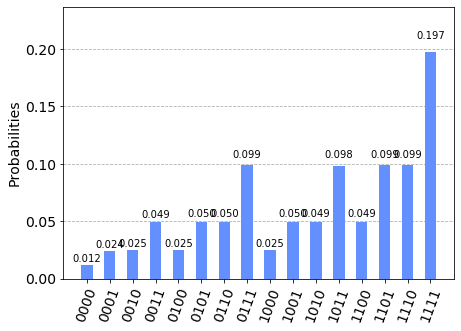

In [28]:
plot_histogram(counts4)

In [29]:
print(counts4)

{'1110': 98904, '0011': 49256, '1101': 98781, '1100': 49420, '0100': 24619, '1000': 24672, '0101': 49765, '1011': 98487, '0110': 49569, '0000': 12271, '0001': 24395, '1111': 197279, '1001': 49583, '0111': 98822, '1010': 49413, '0010': 24764}



|4-qubit state | Probability of the 4-qubit state  | Qiskit result |
|--------------|-----------------------------------|---------------|
|    $\vert 0000>$ | $\frac{1}{3}\cdot \frac{1}{3}\cdot \frac{1}{3} \cdot \frac{1}{3} = \frac{1}{81}=0.012$ | 0.012|
|    $\vert 0001>$ | $\frac{1}{3}\cdot\frac{1}{3}\cdot \frac{1}{3} \cdot \frac{2}{3} = \frac{2}{81}=0.025$ | 0.024|
|    $\vert 0010>$ | $\frac{1}{3}\cdot\frac{1}{3}\cdot \frac{2}{3} \cdot \frac{1}{3} = \frac{2}{81}=0.025$ | 0.025|
|    $\vert 0011>$ | $\frac{1}{3}\cdot \frac{1}{3}\cdot \frac{2}{3}\cdot \frac{2}{3} = \frac{4}{81}=0.049$ | 0.049|
|    $\vert 0100>$ | $\frac{1}{3}\cdot\frac{2}{3} \cdot \frac{1}{3}\cdot \frac{1}{3} = \frac{2}{81}=0.025$ | 0.025|
|    $\vert 0101>$ |  $\frac{1}{3} \cdot \frac{2}{3}\cdot \frac{1}{3}\cdot \frac{2}{3} = \frac{4}{81}=0.049$ | 0.05|
|    $\vert 0110>$ | $ \frac{1}{3}\cdot \frac{2}{3}\cdot \frac{2}{3} \cdot \frac{1}{3} = \frac{4}{81}=0.049$ | 0.05|
|    $\vert 0111>$ | $\frac{1}{3}\cdot \frac{2}{3}\cdot \frac{2}{3}\cdot \frac{2}{3} = \frac{8}{81}=0.099$ | 0.099|
|    $\vert 1000>$ | $\frac{2}{3}\cdot\frac{1}{3}\cdot \frac{1}{3} \cdot \frac{1}{3} = \frac{2}{81}=0.025$ | 0.025|
|    $\vert 1001>$ | $\frac{2}{3}\cdot \frac{1}{3}\cdot \frac{1}{3}\cdot \frac{2}{3} = \frac{4}{81}=0.049$ | 0.050|
|    $\vert 1010>$ | $\frac{2}{3}\cdot \frac{1}{3}\cdot \frac{2}{3}\cdot \frac{1}{3} = \frac{4}{81}=0.049$ | 0.049|
|    $\vert 1011>$ | $\frac{2}{3}\cdot \frac{1}{3}\cdot \frac{2}{3}\cdot \frac{2}{3} = \frac{8}{81}=0.099$ | 0.098|
|    $\vert 1100>$ | $ \frac{2}{3}\cdot \frac{2}{3}\cdot \frac{1}{3} \cdot \frac{1}{3} = \frac{4}{81}=0.049$ | 0.049|
|    $\vert 1101>$ | $\frac{2}{3}\cdot \frac{2}{3}\cdot \frac{1}{3}\cdot \frac{2}{3} = \frac{8}{81}=0.099$ | 0.099|
|    $\vert 1110>$ | $\frac{2}{3}\cdot \frac{2}{3}\cdot \frac{2}{3}\cdot \frac{1}{3} = \frac{8}{81}=0.099$ | 0.099|
|    $\vert 1111>$ | $\frac{2}{3}\cdot \frac{2}{3}\cdot \frac{2}{3}\cdot \frac{2}{3} = \frac{16}{81}=0.198$ | 0.197|

From the results above you can see that the deporalizing error channel $\varepsilon(\rho_{single-qubit})$ works on the qubits like how it was expected with the small error due to statistical fluctuations involved in making measurements.

To conclude the results show that the built in function $\texttt{depolarizing\_error}$ works the way we want it to as the majority of the results were acurate.
When 
$$\lambda=\frac{4^{n}P}{4^{n}-1},$$ 
and $n=1$, $$\lambda = \frac{4P}{3}.$$
The depolarizing channel becomes 
$$\varepsilon(\rho_{single-qubit}) =    
    (1-P)\rho + \frac{P}{3}\left(X\rho X + Y\rho Y + Z\rho Z\right)$$